#**PROJECT 7 - Privacy-preserving synthetic healthcare data generation**

Determinareil trade-off tra livello di privacy e l'effettiva utilità del dataset sintetico

### Installazione liberie e import necessari

In [1]:
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu121

!pip install --quiet sdv==1.29.1

!pip install --quiet ctgan==0.11.1

!pip install smartnoise-synth==1.0.5

!pip install --quiet xgboost joblib


Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 616.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196

In [2]:
import os
import pandas as pd
import numpy as np
import torch
import gc
import pickle
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import wasserstein_distance, entropy

from snsynth import Synthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata

from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import evaluate_quality

from sdv.evaluation.single_table import evaluate_quality, run_diagnostic, get_column_plot

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import joblib
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


In [19]:
#SALVA TUTTE LE CARTELLE E FILE
!zip -r all_colab_files.zip /content

from google.colab import files
files.download("all_colab_files.zip")

updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/config_sentinel (stored 0%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/default_configs.db (deflated 98%)
updating: content/.config/configurations/ (stored 0%)
updating: content/.config/configurations/config_default (deflated 15%)
updating: content/.config/gce (stored 0%)
updating: content/.config/.last_survey_prompt.yaml (stored 0%)
updating: content/.config/.last_opt_in_prompt.yaml (stored 0%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2025.12.09/ (stored 0%)
updating: content/.config/logs/2025.12.09/14.41.18.717681.log (deflated 58%)
updating: content/.config/logs/2025.12.09/14.41.42.675750.log (deflated 57%)
updating: content/.config/logs/2025.12.09/14.40.47.605300.log (deflated 92%)
updating: content/.config/logs/2025.12.09/14.41.33.792924.log (deflated 58%)
updating: content/.config/logs/2025.12.09/14.41.27.893750.log (d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **CARICAMENTO DATASET**

## Scegli se:
- caricare dataset originale già suddiviso e dataset sintetici già realizzati
oppure
- caricare dataset originale, suddividerlo e creare nuovi dati sintetici

### Caricare  dataset originale già suddiviso e dataset sintetici già realizzati:

In [4]:
# Crea le directory se non esistono
os.makedirs("dataset/real", exist_ok=True)
os.makedirs("dataset/synthetic", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [5]:
#Carica dati già fatti
train_df  = pd.read_csv("dataset/real/diabetes_train.csv")
holdout_df = pd.read_csv("dataset/real/diabetes_holdout.csv")
df=train_df

In [6]:
#no privacy
synthetic_noprivacy = pd.read_csv("dataset/synthetic/synthetic_no_privacy.csv")
metadata_noprivacy = SingleTableMetadata()
metadata_noprivacy.detect_from_dataframe(df)
#moderata
synthetic_mod = pd.read_csv("dataset/synthetic/synthetic_privacy_moderata.csv")
metadata_mod = SingleTableMetadata()
metadata_mod.detect_from_dataframe(df)
#strong
synthetic_strong = pd.read_csv("dataset/synthetic/synthetic_privacy_strong.csv")
metadata_strong  = SingleTableMetadata()
metadata_strong.detect_from_dataframe(df)

### Carica dataset, suddividilo ed esegui realizzazione dataset sintetici:

In [ ]:
def carica_dataset():
    path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset")
    csv_path = os.path.join(path, "diabetes_binary_health_indicators_BRFSS2015.csv")
    df = pd.read_csv(csv_path)
    df = df.rename(columns={'Diabetes_binary': 'outcome'})
    print(f"Dataset caricato: {df.shape[0]} righe e {df.shape[1]} colonne")
    return df

def preprocessa_dataset(df):
    df = df.astype(float)
    df = df.astype('int64')

    return df

# Crea le directory se non esistono
os.makedirs("dataset/real", exist_ok=True)
os.makedirs("dataset/synthetic", exist_ok=True)
os.makedirs("models", exist_ok=True)

df = carica_dataset()
df = preprocessa_dataset(df)
df.info()

train_df, holdout_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['outcome']
)

train_df.to_csv('dataset/real/diabetes_train.csv', index=False)
holdout_df.to_csv('dataset/real/diabetes_holdout.csv', index=False)

print(f"Dimensione train: {train_df.shape}")
print(f"Dimensione holdout: {holdout_df.shape}")

100%|██████████| 6.03M/6.03M [00:01<00:00, 4.59MB/s]

Extracting files...


Dataset caricato: 253680 righe e 22 colonne
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   outcome               253680 non-null  int64
 1   HighBP                253680 non-null  int64
 2   HighChol              253680 non-null  int64
 3   CholCheck             253680 non-null  int64
 4   BMI                   253680 non-null  int64
 5   Smoker                253680 non-null  int64
 6   Stroke                253680 non-null  int64
 7   HeartDiseaseorAttack  253680 non-null  int64
 8   PhysActivity          253680 non-null  int64
 9   Fruits                253680 non-null  int64
 10  Veggies               253680 non-null  int64
 11  HvyAlcoholConsump     253680 non-null  int64
 12  AnyHealthcare         253680 non-null  int64
 13  NoDocbcCost           253680 non-null  int64
 14  GenHlth               253680 non-null  i

## **GENERAZIONE DATI SINTETICI**

## NO PRIVACY

In [ ]:
def synthetic_no_privacy(df):

    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)

    for col in df.columns:
        if col in ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']:
            metadata.update_column(col, sdtype='numerical')
        else:
            metadata.update_column(col, sdtype='categorical')

    model = CTGANSynthesizer(
        metadata,
        epochs=50,
        batch_size=2000,
        generator_dim=(256, 256, 256),
        discriminator_dim=(256, 256, 256),
        verbose=True,
        pac=10,
        cuda=True
    )

    print("Inizio addestramento CTGAN su dataset CDC...")
    model.fit(df)

    num_samples = len(df)
    print(f"Generazione di {num_samples} campioni...")
    synthetic = model.sample(num_samples)

    os.makedirs("models", exist_ok=True)
    model.save("models/ctgan_no_privacy.pkl")

    return synthetic, metadata

synthetic_noprivacy, metadata_noprivacy = synthetic_no_privacy(train_df)
synthetic_noprivacy.to_csv('dataset/synthetic/synthetic_no_privacy.csv', index=False)

Inizio addestramento CTGAN su dataset CDC...


Gen. (-3.90) | Discrim. (-0.11): 100%|██████████| 50/50 [05:07<00:00,  6.16s/it]


Generazione di 202944 campioni...


## CON PRIVACY

In [ ]:
def synthetic_dpctgan(df, epsilon, model_path):
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(data=df)
    gc.collect()
    torch.cuda.empty_cache()

    use_cuda = torch.cuda.is_available()
    print(f"Device rilevato: {'cuda' if use_cuda else 'cpu'}")

    synth = Synthesizer.create(
        synth="dpctgan",
        epsilon=epsilon,
        epochs=300,
        batch_size=2000,
        verbose=True,
        cuda=use_cuda
    )

    print(f"Inizio training DP-CTGAN (ε={epsilon})...")

    synth.fit(df)

    df_synt = synth.sample(len(df))

    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    with open(model_path, 'wb') as f:
        pickle.dump(synth, f)
    print(f"Modello salvato con successo in: {model_path}")

    return df_synt, metadata


In [ ]:
# PRIVACY MODERATA
print("Generazione privacy moderata...")
synthetic_mod, metadata_mod = synthetic_dpctgan(train_df, epsilon=4.0,model_path="models/privacy_moderata.pkl")
synthetic_mod.to_csv("dataset/synthetic/synthetic_privacy_moderata.csv", index=False)

Generazione privacy moderata...
Device rilevato: cuda
Inizio training DP-CTGAN (ε=4.0)...
Epoch 1, Loss G: 0.6626, Loss D: 1.3954
epsilon is 0.21283664753187329, alpha is 63.0
Epoch 2, Loss G: 0.6893, Loss D: 1.3875
epsilon is 0.23869863329550584, alpha is 63.0
Epoch 3, Loss G: 0.6862, Loss D: 1.3872
epsilon is 0.26456061905913836, alpha is 63.0
Epoch 4, Loss G: 0.6849, Loss D: 1.3831
epsilon is 0.2904226048227709, alpha is 63.0
Epoch 5, Loss G: 0.6750, Loss D: 1.3890
epsilon is 0.3162845905864034, alpha is 63.0
Epoch 6, Loss G: 0.6672, Loss D: 1.3877
epsilon is 0.3421465763500359, alpha is 63.0
Epoch 7, Loss G: 0.6713, Loss D: 1.3873
epsilon is 0.36800856211366845, alpha is 63.0
Epoch 8, Loss G: 0.6716, Loss D: 1.3891
epsilon is 0.393870547877301, alpha is 63.0
Epoch 9, Loss G: 0.6710, Loss D: 1.3870
epsilon is 0.41973253364093355, alpha is 63.0
Epoch 10, Loss G: 0.6665, Loss D: 1.3826
epsilon is 0.44555709216861406, alpha is 62.0
Epoch 11, Loss G: 0.6597, Loss D: 1.3834
epsilon is 0.

In [ ]:
# PRIVACY STRONG
print("Generazione privacy strong...")
synthetic_strong, metadata_strong = synthetic_dpctgan(train_df, epsilon=2.0,model_path="models/privacy_strong.pkl")
synthetic_strong.to_csv("dataset/synthetic/synthetic_privacy_strong.csv", index=False)

Generazione privacy strong...
Device rilevato: cuda
Inizio training DP-CTGAN (ε=2.0)...
Epoch 1, Loss G: 0.6622, Loss D: 1.3960
epsilon is 0.21283664753187329, alpha is 63.0
Epoch 2, Loss G: 0.6966, Loss D: 1.3820
epsilon is 0.23869863329550584, alpha is 63.0
Epoch 3, Loss G: 0.6845, Loss D: 1.3879
epsilon is 0.26456061905913836, alpha is 63.0
Epoch 4, Loss G: 0.6815, Loss D: 1.3932
epsilon is 0.2904226048227709, alpha is 63.0
Epoch 5, Loss G: 0.6694, Loss D: 1.3765
epsilon is 0.3162845905864034, alpha is 63.0
Epoch 6, Loss G: 0.6636, Loss D: 1.3923
epsilon is 0.3421465763500359, alpha is 63.0
Epoch 7, Loss G: 0.6723, Loss D: 1.3920
epsilon is 0.36800856211366845, alpha is 63.0
Epoch 8, Loss G: 0.6674, Loss D: 1.3856
epsilon is 0.393870547877301, alpha is 63.0
Epoch 9, Loss G: 0.6613, Loss D: 1.3905
epsilon is 0.41973253364093355, alpha is 63.0
Epoch 10, Loss G: 0.6619, Loss D: 1.3849
epsilon is 0.44555709216861406, alpha is 62.0
Epoch 11, Loss G: 0.6604, Loss D: 1.3850
epsilon is 0.47

### **VALUTAZIONE SOMIGLIANZA STATISTICA**

ANALISI QUALITA' DEI DATI SINTETICI

In [7]:
def valuta_qualita_dataset(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI QUALITÀ: {nome} =====")

    # 1) DIAGNOSTICA
    print("\n--- Diagnostic Report ---")
    diagnostic = run_diagnostic(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata
    )

    # 2) QUALITY REPORT
    quality_report = evaluate_quality(
        real_data=real,
        synthetic_data=synth,
        metadata=metadata,
        verbose=False
    )
    print("\n--- Quality Score ---")
    print(quality_report.get_score())

    return diagnostic, quality_report

datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

diagnostics = {}
quality_reports = {}

for nome, synth_df, meta in datasets_sintetici:
    diag, q_report = valuta_qualita_dataset(df, synth_df, meta, nome)
    diagnostics[nome] = diag
    quality_reports[nome] = q_report



===== ANALISI QUALITÀ: NO PRIVACY =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 22/22 [00:00<00:00, 176.73it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 238.06it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Quality Score ---
0.8427667263359448

===== ANALISI QUALITÀ: PRIVACY MODERATA =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 22/22 [00:00<00:00, 196.99it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 330.31it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%


--- Quality Score ---
0.9052615428912263

===== ANALISI QUALITÀ: PRIVACY STRONG =====

--- Diagnostic Report ---
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 22/22 [00:00<00:00, 194.74it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure:

ANALISI SOMIGLIANZA STATISTICA DEI DATI SINTETICI


===== ANALISI SOMIGLIANZA STATISTICA: NO PRIVACY =====

Confronto media e deviazione standard tra reale e sintetico:
Feature                       Mean_Real  Mean_Sint      ΔMean   Std_Real   Std_Sint       ΔStd
outcome                          0.1393     0.2721     0.1327     0.3463     0.4450     0.0987
HighBP                           0.4290     0.3993    -0.0297     0.4949     0.4898    -0.0052
HighChol                         0.4243     0.5731     0.1488     0.4942     0.4946     0.0004
CholCheck                        0.9624     0.9165    -0.0460     0.1902     0.2767     0.0865
BMI                             28.3780    29.8513     1.4734     6.5983     6.5600    -0.0383
Smoker                           0.4429     0.5495     0.1066     0.4967     0.4975     0.0008
Stroke                           0.0404     0.1698     0.1294     0.1969     0.3754     0.1785
HeartDiseaseorAttack             0.0942     0.2894     0.1952     0.2922     0.4535     0.1613
PhysActivity               

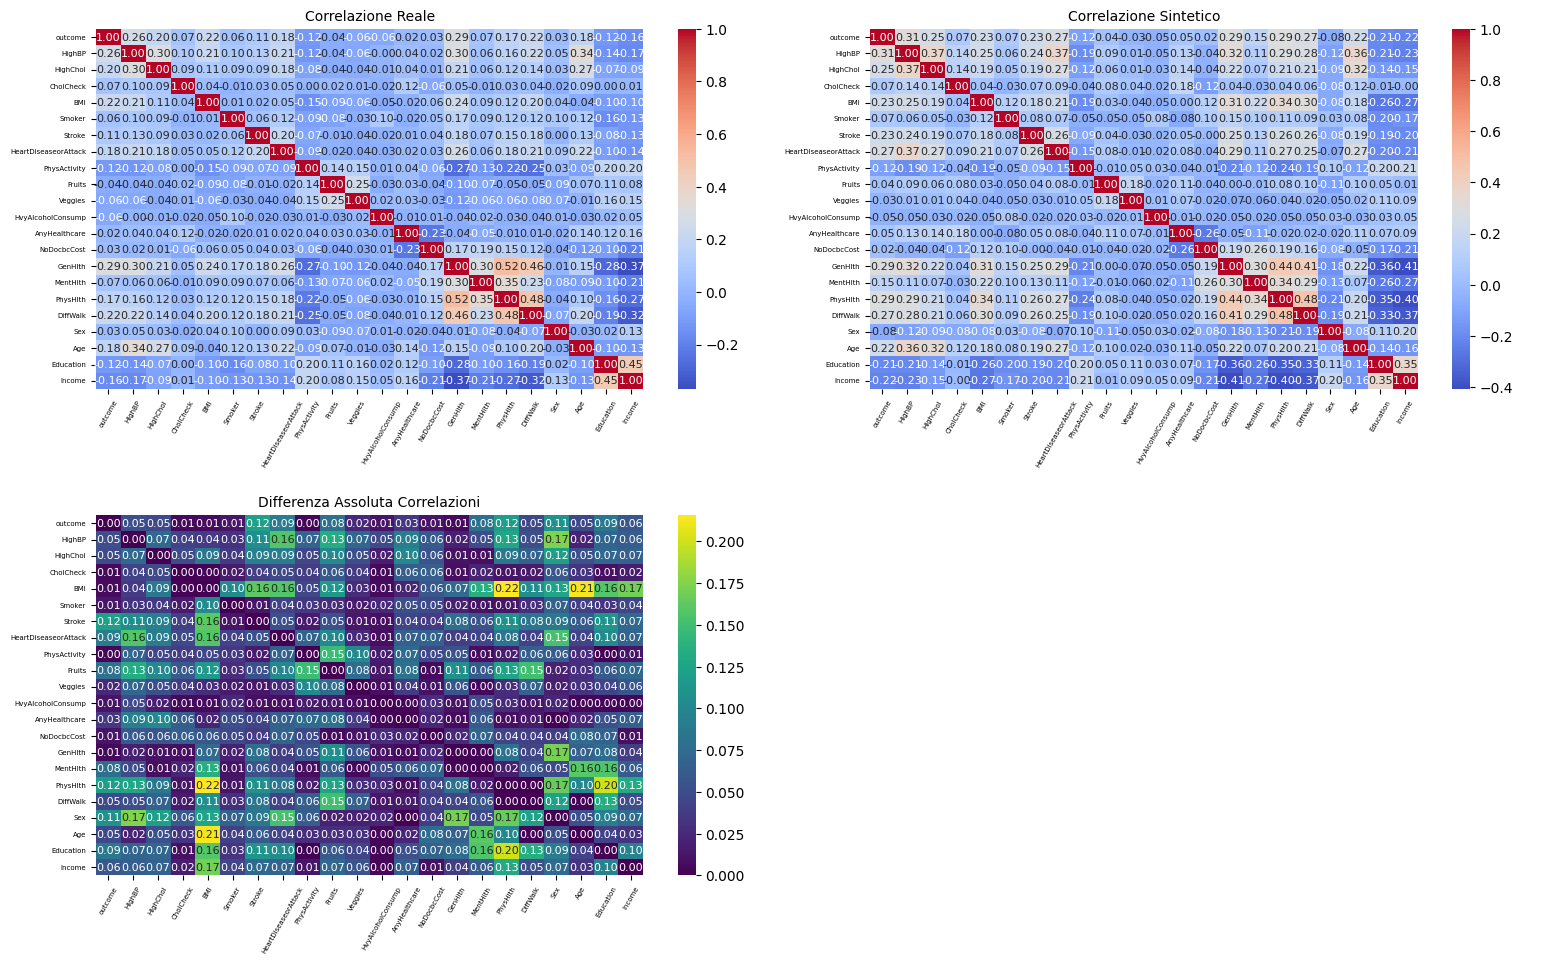

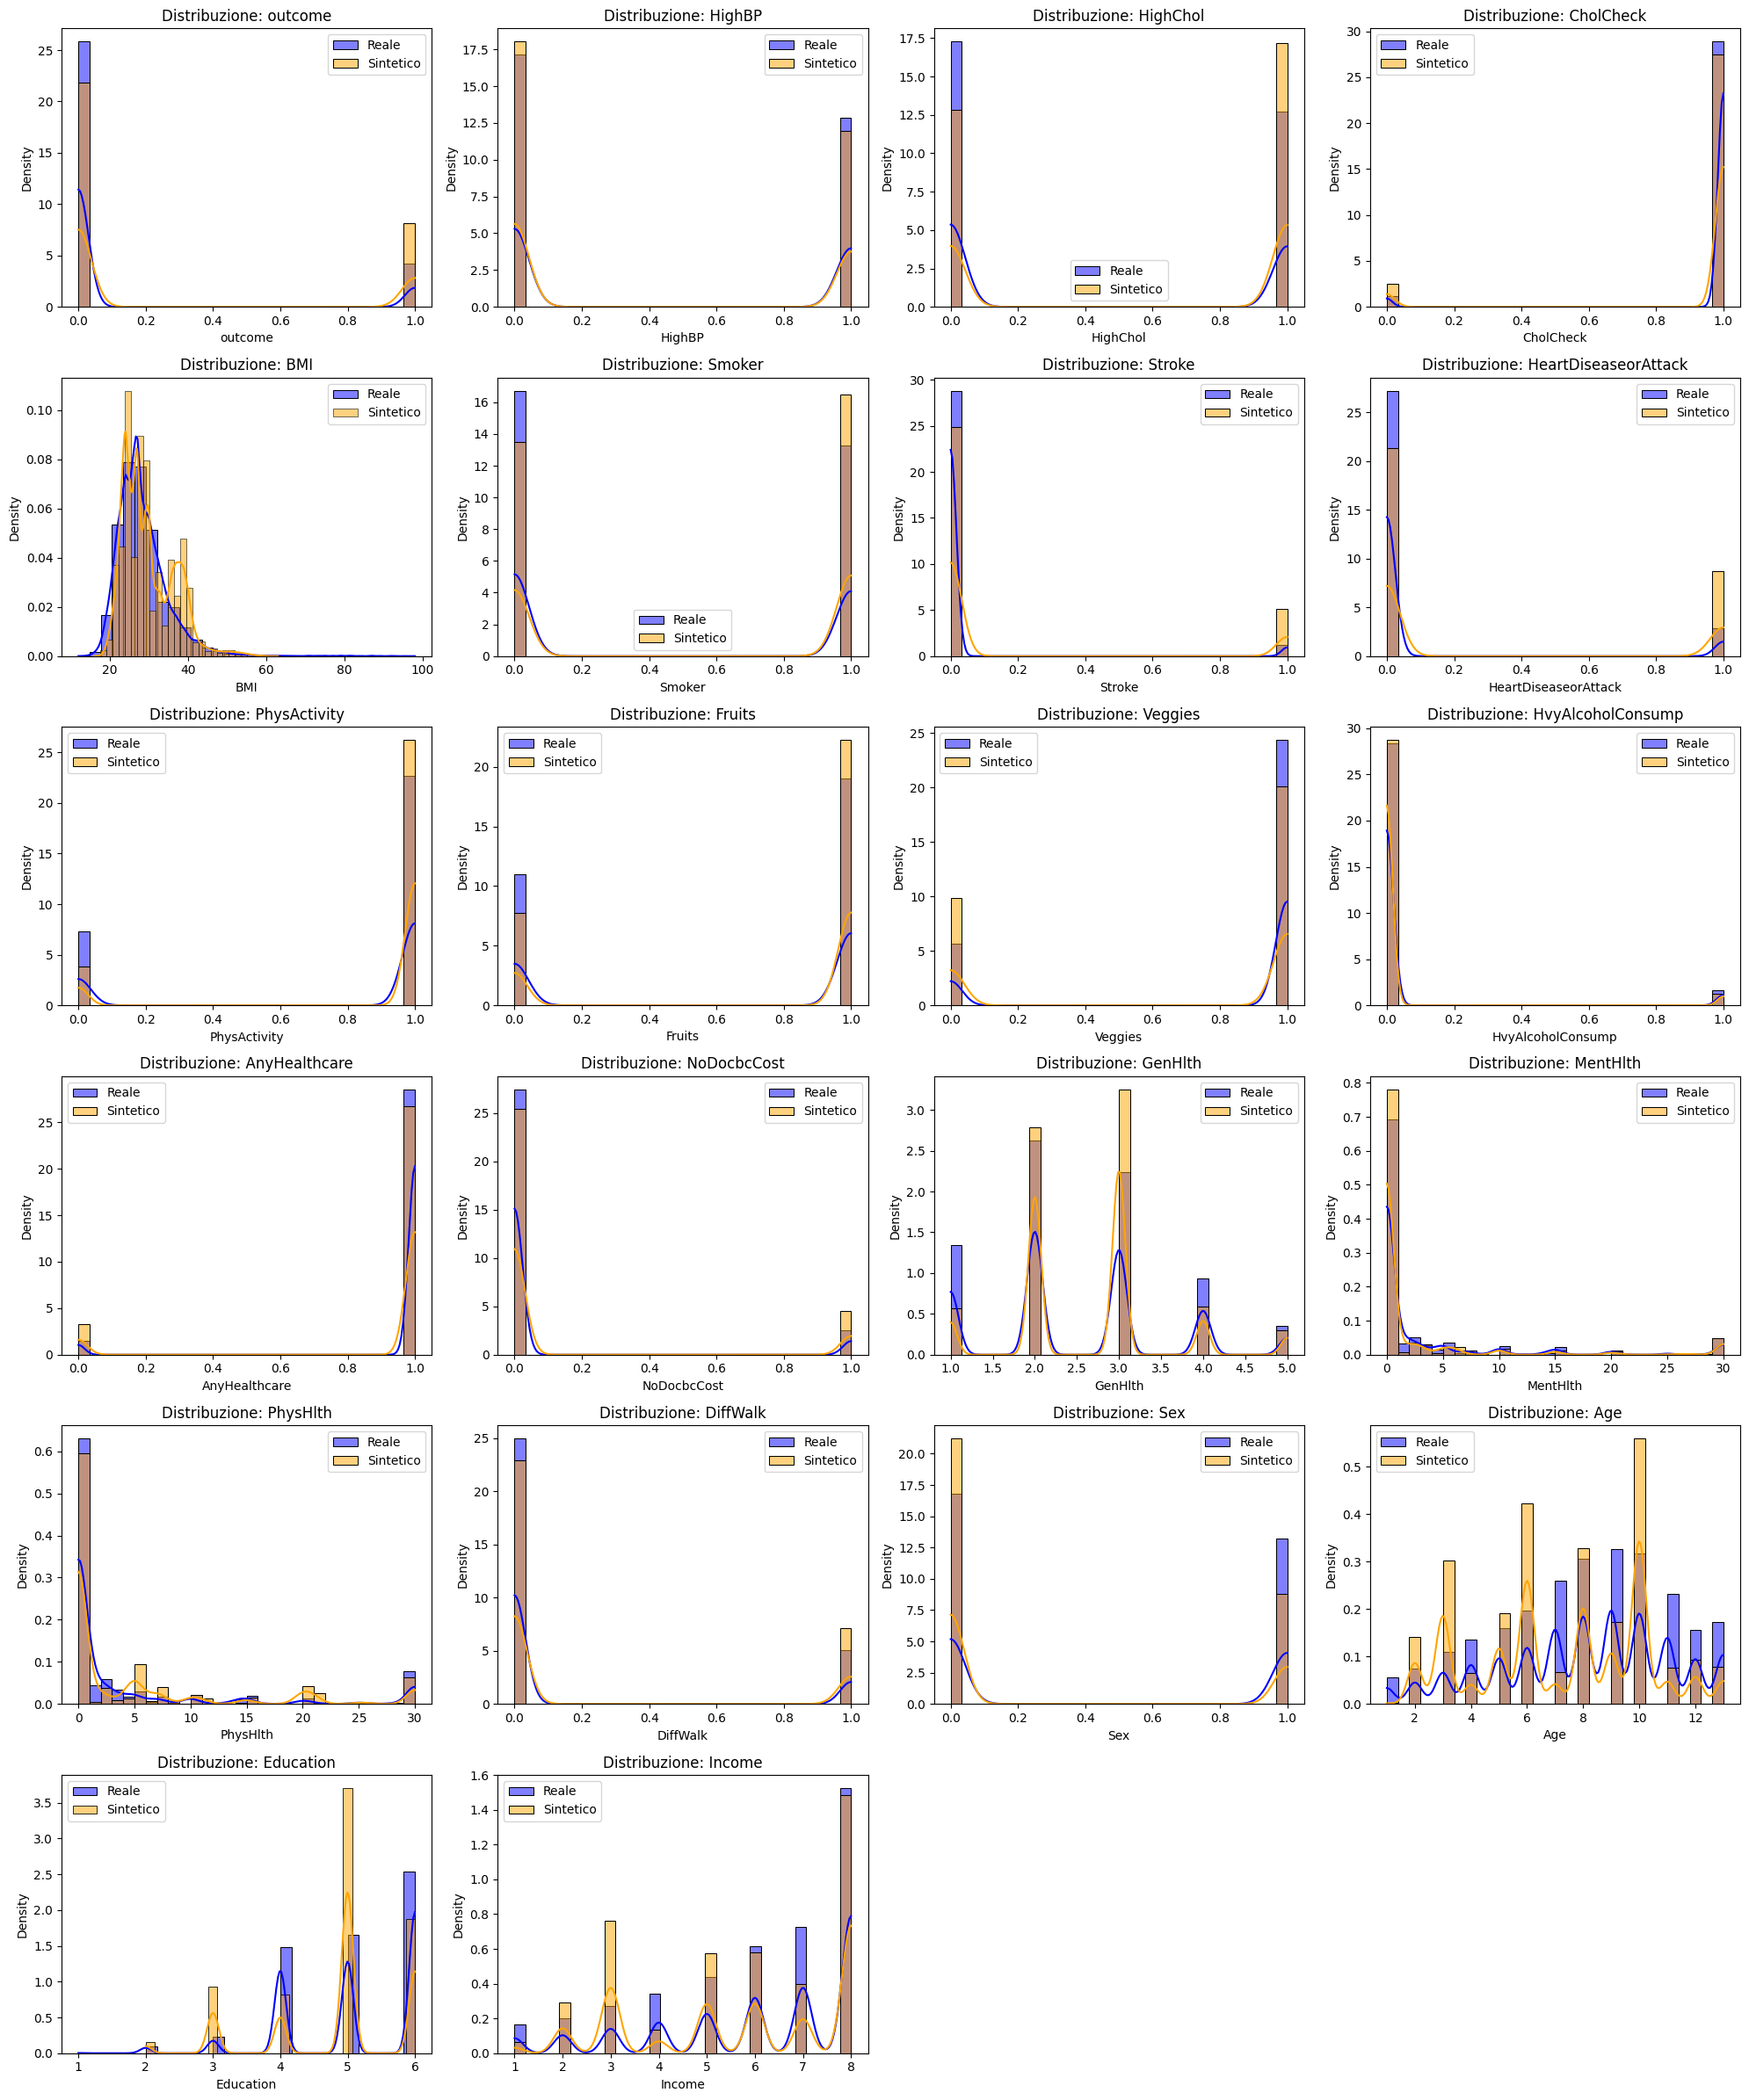


===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY MODERATA =====

Confronto media e deviazione standard tra reale e sintetico:
Feature                       Mean_Real  Mean_Sint      ΔMean   Std_Real   Std_Sint       ΔStd
outcome                          0.1393     0.1543     0.0150     0.3463     0.3613     0.0150
HighBP                           0.4290     0.4272    -0.0018     0.4949     0.4947    -0.0003
HighChol                         0.4243     0.3791    -0.0452     0.4942     0.4852    -0.0091
CholCheck                        0.9624     0.9952     0.0328     0.1902     0.0693    -0.1209
BMI                             28.3780    26.2926    -2.0853     6.5983     3.0377    -3.5606
Smoker                           0.4429     0.4440     0.0011     0.4967     0.4969     0.0001
Stroke                           0.0404     0.0319    -0.0085     0.1969     0.1758    -0.0211
HeartDiseaseorAttack             0.0942     0.0615    -0.0327     0.2922     0.2403    -0.0519
PhysActivity         

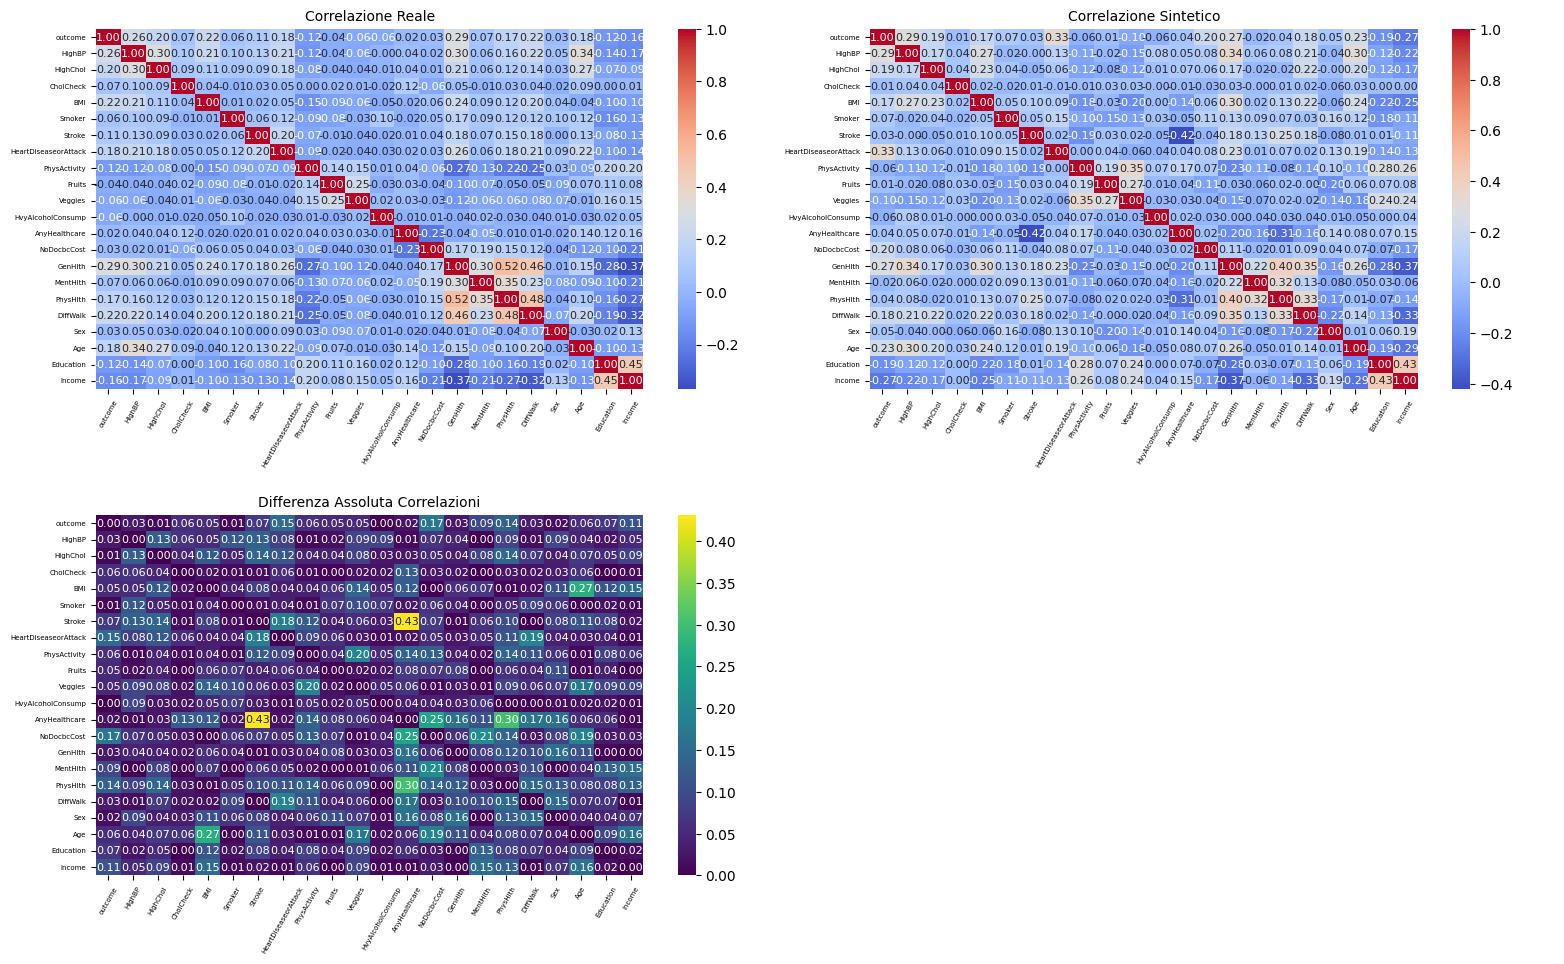

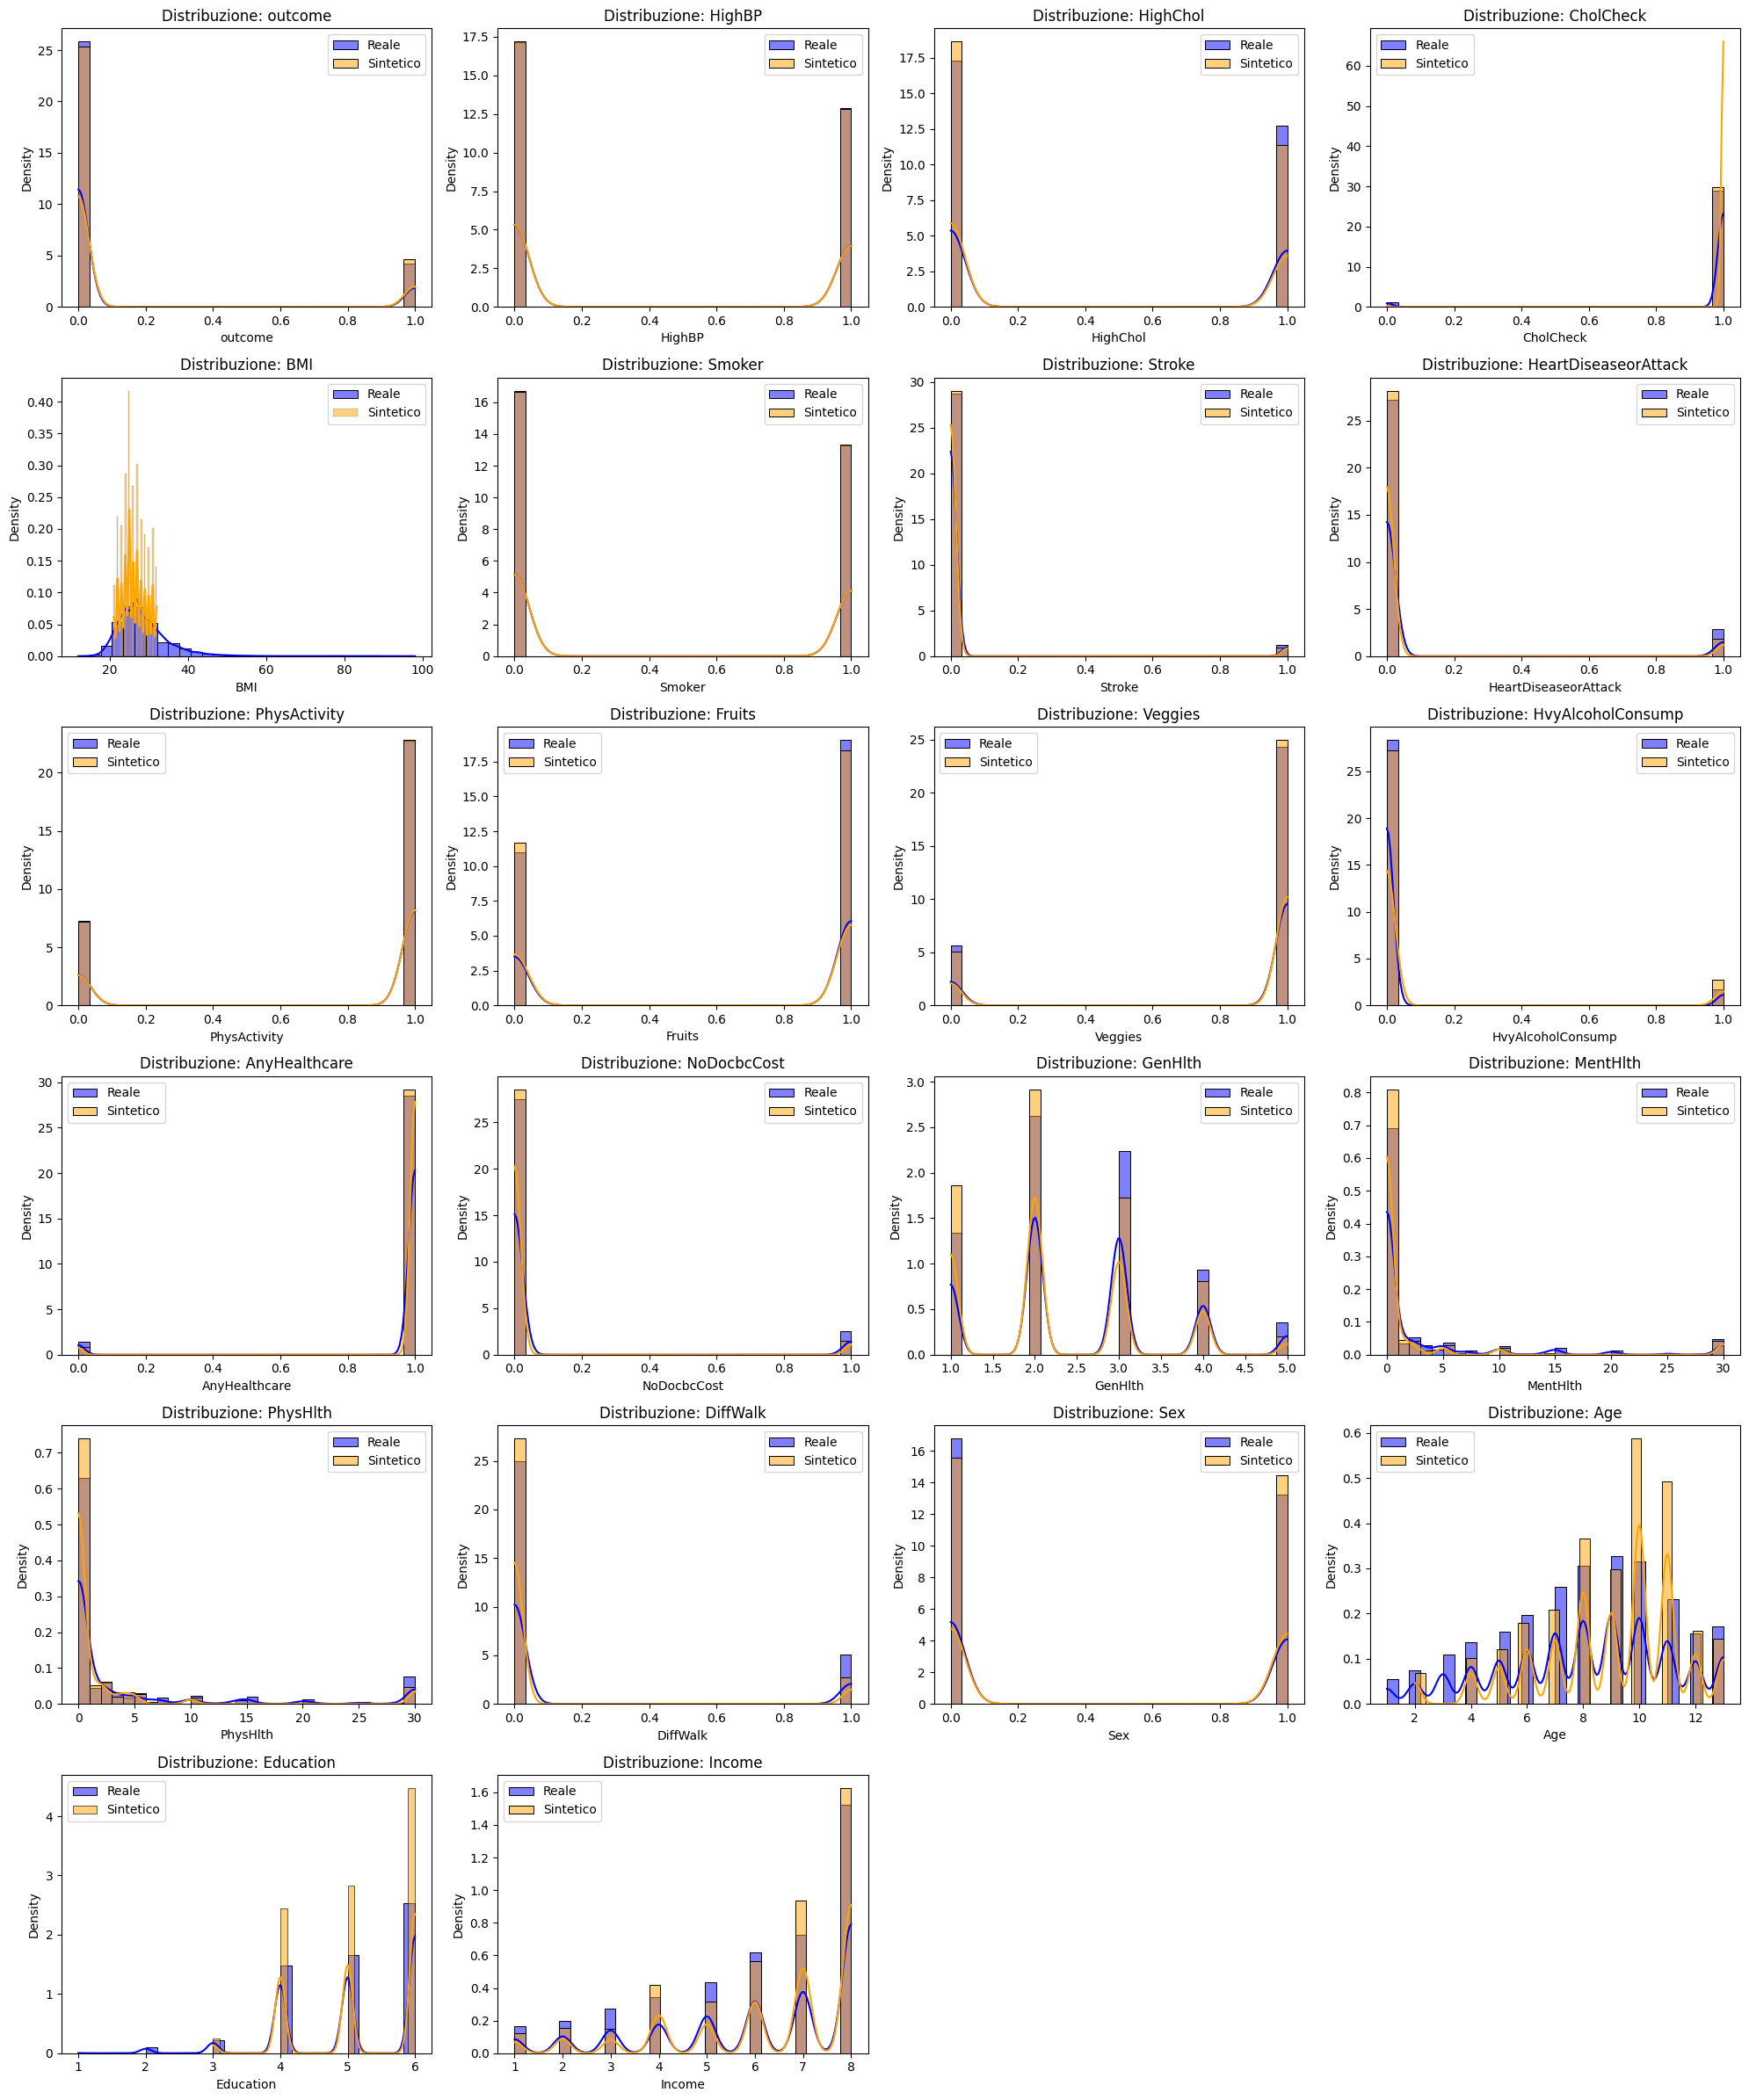


===== ANALISI SOMIGLIANZA STATISTICA: PRIVACY STRONG =====

Confronto media e deviazione standard tra reale e sintetico:
Feature                       Mean_Real  Mean_Sint      ΔMean   Std_Real   Std_Sint       ΔStd
outcome                          0.1393     0.1404     0.0011     0.3463     0.3474     0.0011
HighBP                           0.4290     0.3828    -0.0462     0.4949     0.4861    -0.0089
HighChol                         0.4243     0.3805    -0.0438     0.4942     0.4855    -0.0087
CholCheck                        0.9624     0.9711     0.0087     0.1902     0.1674    -0.0228
BMI                             28.3780    26.3839    -1.9940     6.5983     3.2048    -3.3935
Smoker                           0.4429     0.3241    -0.1188     0.4967     0.4680    -0.0287
Stroke                           0.0404     0.0563     0.0159     0.1969     0.2305     0.0336
HeartDiseaseorAttack             0.0942     0.0658    -0.0284     0.2922     0.2480    -0.0442
PhysActivity           

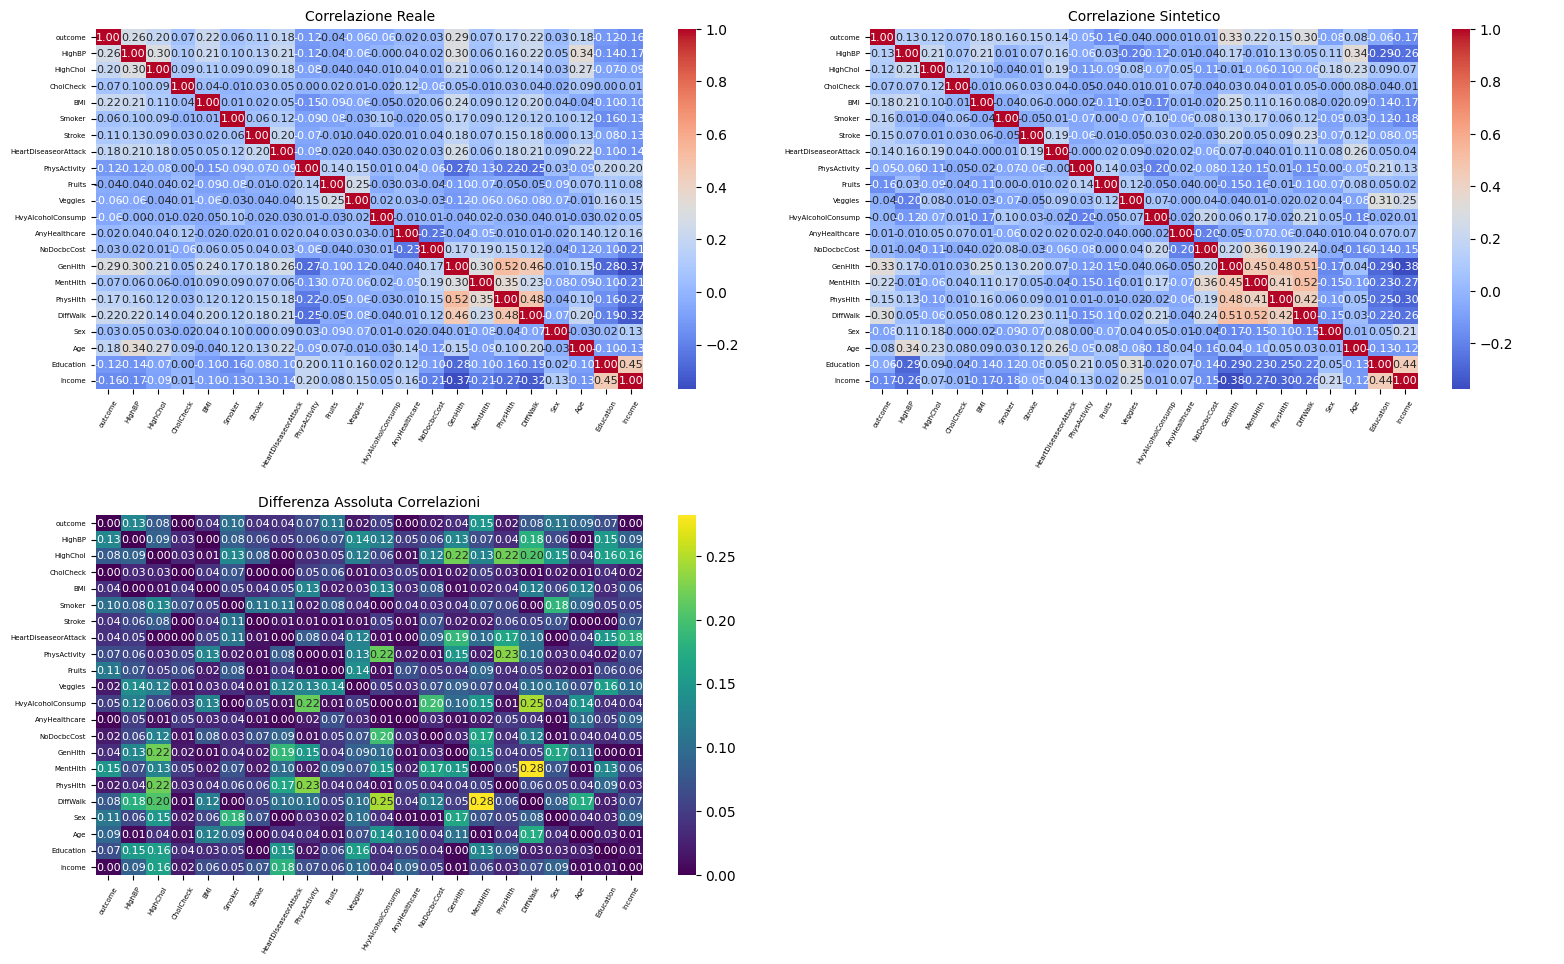

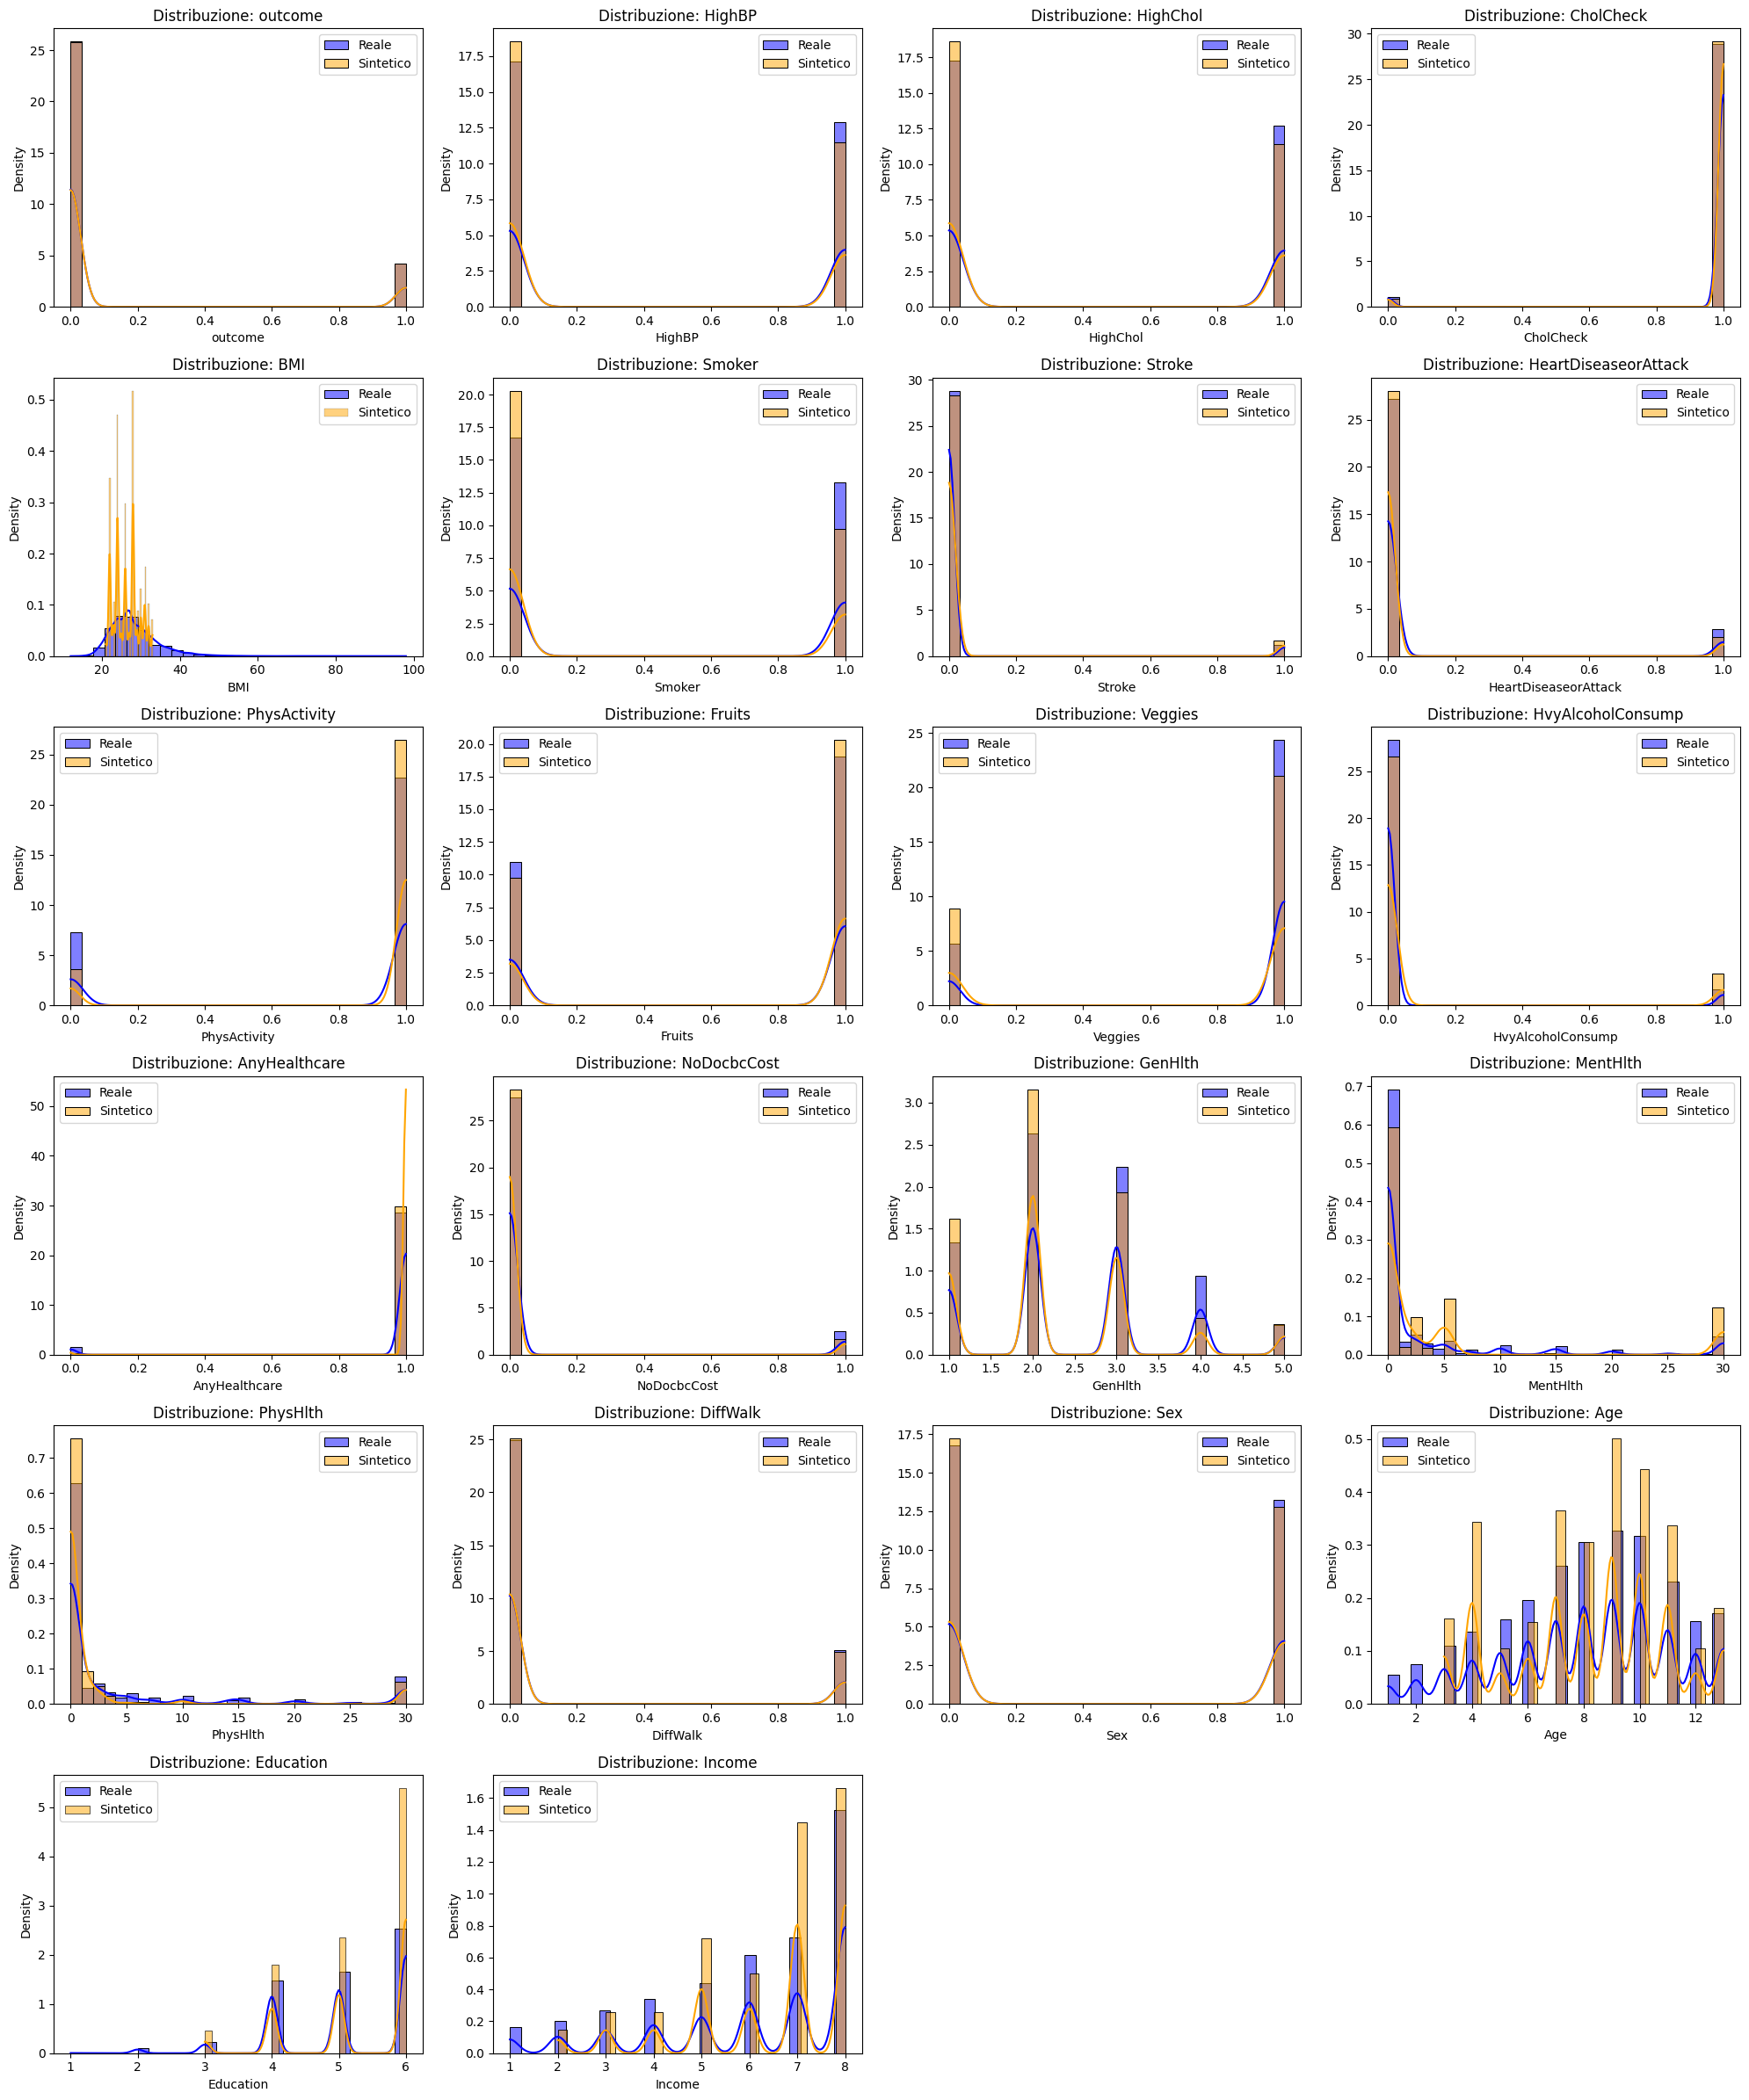

In [8]:
def somiglianza_statistica(real, synth, metadata, nome=""):
    print(f"\n===== ANALISI SOMIGLIANZA STATISTICA: {nome} =====")

    num_cols = [col for col in real.columns if pd.api.types.is_numeric_dtype(real[col])]
    cat_cols = [col for col in real.columns if pd.api.types.is_categorical_dtype(real[col])
                or real[col].nunique() < 20]

    print("\nConfronto media e deviazione standard tra reale e sintetico:")
    print("{:<28} {:>10} {:>10} {:>10} {:>10} {:>10} {:>10}".format(
        'Feature',
        'Mean_Real',
        'Mean_Sint',
        'ΔMean',
        'Std_Real',
        'Std_Sint',
        'ΔStd'
    ))

    for col in num_cols:
        mean_real = real[col].mean()
        mean_synth = synth[col].mean()
        std_real = real[col].std()
        std_synth = synth[col].std()

        diff_mean = mean_synth - mean_real
        diff_std = std_synth - std_real

        print("{:<28} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f}".format(
            col,
            mean_real,
            mean_synth,
            diff_mean,
            std_real,
            std_synth,
            diff_std
        ))


    # 2. Confronto MATRICE DI CORRELAZIONE
    real_corr = real[num_cols].corr()
    synth_corr = synth[num_cols].corr()
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    frobenius_distance = np.linalg.norm(real_corr.values - synth_corr.values, ord='fro')
    print(f"\nDistanza di Frobenius tra le matrici di correlazione: {frobenius_distance:.2f}")
    print("\nConfronto MATRICE DI CORRELAZIONE:")
    # Prima riga:
    sns.heatmap(real_corr, ax=axes[0, 0], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 0].set_title('Correlazione Reale', fontsize=10)
    axes[0, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 0].tick_params(axis='y', labelsize=5)
    sns.heatmap(synth_corr, ax=axes[0, 1], cmap='coolwarm', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[0, 1].set_title('Correlazione Sintetico', fontsize=10)
    axes[0, 1].tick_params(axis='x', labelsize=5, rotation=60)
    axes[0, 1].tick_params(axis='y', labelsize=5)
    # Seconda riga:
    axes[1, 1].axis('off')
    sns.heatmap(abs(real_corr - synth_corr), ax=axes[1, 0], cmap='viridis', annot=True, fmt='.2f', annot_kws={"size":8})
    axes[1, 0].set_title('Differenza Assoluta Correlazioni', fontsize=10)
    axes[1, 0].tick_params(axis='x', labelsize=5, rotation=60)
    axes[1, 0].tick_params(axis='y', labelsize=5)
    plt.tight_layout(pad=2)
    plt.show()


    # 3. Confronto DISTRIBUZIONI
    num_per_row = 4
    num_cols_total = len(num_cols)
    num_rows = int(np.ceil(num_cols_total / num_per_row))
    fig_width = 20
    fig_height = 4 * num_rows
    fig, axes = plt.subplots(num_rows, num_per_row, figsize=(fig_width, fig_height))
    axes = axes.flatten()
    for ax, col in zip(axes, num_cols):
        sns.histplot(real[col], color='blue', label='Reale', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        sns.histplot(synth[col], color='orange', label='Sintetico', kde=True, stat="density", bins=30, alpha=0.5, ax=ax)
        ax.set_title(f'Distribuzione: {col}')
        ax.set_ylabel('Density')
        ax.set_xlabel(col)
        ax.legend()
    for ax in axes[len(num_cols):]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()


datasets_sintetici = [
    ("NO PRIVACY", synthetic_noprivacy, metadata_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod, metadata_mod),
    ("PRIVACY STRONG", synthetic_strong, metadata_strong)
]

for nome, synth_df, meta in datasets_sintetici:
    somiglianza_statistica(df, synth_df, meta, nome)


## **VALUTARE UTILITA' PER LA RICERCA**: addestrare modelli di predizione delle malattie su dati sintetici e valutarli su un set reale di holdout

**TSTR (Train on Synthetic, Test on Real)**: TRINING DEI MODELLI CON I DIVERSI DATASET SINTETICI GENERATI (NO PRIVACY, MODERATA, STRONG) E TEST SU DATI REALI HOLDOUT

In [9]:
# Configurazione dei dataset
datasets = [
    ("NO PRIVACY", synthetic_noprivacy),
    ("PRIVACY MODERATA", synthetic_mod),
    ("PRIVACY STRONG", synthetic_strong)
]

X_test = holdout_df.drop('outcome', axis=1)
y_test = holdout_df['outcome']
risultati_finali = []

def valuta_e_stampa(y_true, y_pred, y_pred_proba, nome_modello, config_name):
    """Calcola le metriche, le stampa immediatamente e le salva."""
    res = {
        'Configurazione': config_name,
        'Modello': nome_modello,
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0)
    }
    risultati_finali.append(res)
    print(f"   {nome_modello} -> Accuracy: {res['Accuracy']:.4f} | ROC-AUC: {res['ROC-AUC']:.4f}")
    return res

def get_scale_weight(df):
    """Calcola lo scale_pos_weight basandosi sullo sbilanciamento del dataset fornito."""
    counts = df['outcome'].value_counts()
    return counts.get(0, 1) / counts.get(1, 1)

def train_mlp(X, y):
    mlp = MLPClassifier(
        hidden_layer_sizes=(32, 16),
        max_iter=200,
        tol=1e-3,
        early_stopping=True,
        random_state=42
    )

    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('oversampler', RandomOverSampler(sampling_strategy='minority', random_state=42)),
        ('model', mlp)
    ])

    pipeline.fit(X, y)

    return pipeline

# 1. BASELINE: DATI REALI
print("\nTraining su DATI REALI e testing su HOLDOUT\n")
X_train_real = train_df.drop('outcome', axis=1)
y_train_real = train_df['outcome']
sw_real = get_scale_weight(train_df)
weights_real = np.where(y_train_real == 1, sw_real, 1.0)

# LR Real
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42).fit(X_train_real, y_train_real)
valuta_e_stampa(y_test, lr.predict(X_test), lr.predict_proba(X_test)[:, 1], "LR", "REAL")

# RF Real
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42).fit(X_train_real, y_train_real)
valuta_e_stampa(y_test, rf.predict(X_test), rf.predict_proba(X_test)[:, 1], "RF", "REAL")

# XGB Real
xgb = XGBClassifier(n_estimators=100, scale_pos_weight=sw_real, eval_metric='logloss', random_state=42).fit(X_train_real, y_train_real)
valuta_e_stampa(y_test, xgb.predict(X_test), xgb.predict_proba(X_test)[:, 1], "XGB", "REAL")

# MLP Real
mlp = train_mlp(X_train_real, y_train_real)
valuta_e_stampa(y_test, mlp.predict(X_test), mlp.predict_proba(X_test)[:, 1], "MLP", "REAL")

# 2. MODELLI SU DATI SINTETICI
for nome_config, synth_df in datasets:
    print(f"\nTraining su {nome_config} e testing su HOLDOUT\n")
    X_train_synth = synth_df.drop('outcome', axis=1)
    y_train_synth = synth_df['outcome']
    sw_synth = get_scale_weight(synth_df)
    weights_synth = np.where(y_train_synth == 1, sw_synth, 1.0)

    # LR Synth
    lr_s = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42).fit(X_train_synth, y_train_synth)
    valuta_e_stampa(y_test, lr_s.predict(X_test), lr_s.predict_proba(X_test)[:, 1], "LR", nome_config)

    # RF Synth
    rf_s = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42).fit(X_train_synth, y_train_synth)
    valuta_e_stampa(y_test, rf_s.predict(X_test), rf_s.predict_proba(X_test)[:, 1], "RF", nome_config)

    # XGB Synth
    xgb_s = XGBClassifier(n_estimators=100, scale_pos_weight=sw_synth, eval_metric='logloss', random_state=42).fit(X_train_synth, y_train_synth)
    valuta_e_stampa(y_test, xgb_s.predict(X_test), xgb_s.predict_proba(X_test)[:, 1], "XGB", nome_config)

    # MLP Synth
    mlp_s = train_mlp(X_train_synth, y_train_synth)
    valuta_e_stampa(y_test, mlp_s.predict(X_test), mlp_s.predict_proba(X_test)[:, 1], "MLP", nome_config)



Training su DATI REALI e testing su HOLDOUT

   LR -> Accuracy: 0.7317 | ROC-AUC: 0.8196
   RF -> Accuracy: 0.8577 | ROC-AUC: 0.7921
   XGB -> Accuracy: 0.7284 | ROC-AUC: 0.8218
   MLP -> Accuracy: 0.7139 | ROC-AUC: 0.8241

Training su NO PRIVACY e testing su HOLDOUT

   LR -> Accuracy: 0.7478 | ROC-AUC: 0.8022
   RF -> Accuracy: 0.8416 | ROC-AUC: 0.7386
   XGB -> Accuracy: 0.7636 | ROC-AUC: 0.7735
   MLP -> Accuracy: 0.7590 | ROC-AUC: 0.7952

Training su PRIVACY MODERATA e testing su HOLDOUT

   LR -> Accuracy: 0.7058 | ROC-AUC: 0.7958
   RF -> Accuracy: 0.8342 | ROC-AUC: 0.7551
   XGB -> Accuracy: 0.7471 | ROC-AUC: 0.7471
   MLP -> Accuracy: 0.7008 | ROC-AUC: 0.7601

Training su PRIVACY STRONG e testing su HOLDOUT

   LR -> Accuracy: 0.6717 | ROC-AUC: 0.7735
   RF -> Accuracy: 0.8418 | ROC-AUC: 0.7432
   XGB -> Accuracy: 0.7402 | ROC-AUC: 0.7529
   MLP -> Accuracy: 0.6758 | ROC-AUC: 0.7508


In [15]:
# 3. TABELLA RIASSUNTIVA FINALE
print("\n" + "-"*25 + "TABELLA RIASSUNTIVA FINALE" + "-"*25)
df_risultati = pd.DataFrame(risultati_finali)
print(df_risultati.to_string(index=False))

df_risultati.to_csv('risultati_modelli_classificazione.csv', index=False) #aggiunta


-------------------------TABELLA RIASSUNTIVA FINALE-------------------------
  Configurazione Modello  Accuracy  ROC-AUC  Precision   Recall  F1-Score
            REAL      LR  0.731650 0.819635   0.310831 0.760787  0.441344
            REAL      RF  0.857675 0.792103   0.468543 0.160136  0.238693
            REAL     XGB  0.728398 0.821811   0.310005 0.774508  0.442782
            REAL     MLP  0.713931 0.824121   0.301329 0.798699  0.437573
      NO PRIVACY      LR  0.747792 0.802150   0.314576 0.687226  0.431592
      NO PRIVACY      RF  0.841611 0.738595   0.377626 0.211062  0.270780
      NO PRIVACY     XGB  0.763639 0.773500   0.316155 0.598812  0.413823
      NO PRIVACY     MLP  0.758988 0.795197   0.321624 0.657943  0.432048
PRIVACY MODERATA      LR  0.705791 0.795804   0.288194 0.756260  0.417347
PRIVACY MODERATA      RF  0.834201 0.755081   0.354244 0.230867  0.279548
PRIVACY MODERATA     XGB  0.747103 0.747112   0.287443 0.551139  0.377831
PRIVACY MODERATA     MLP  0.700765

**ANALISI DEGRADAZIONE ROC-AUC PER I DIVERSI MODELLI TESTATI**

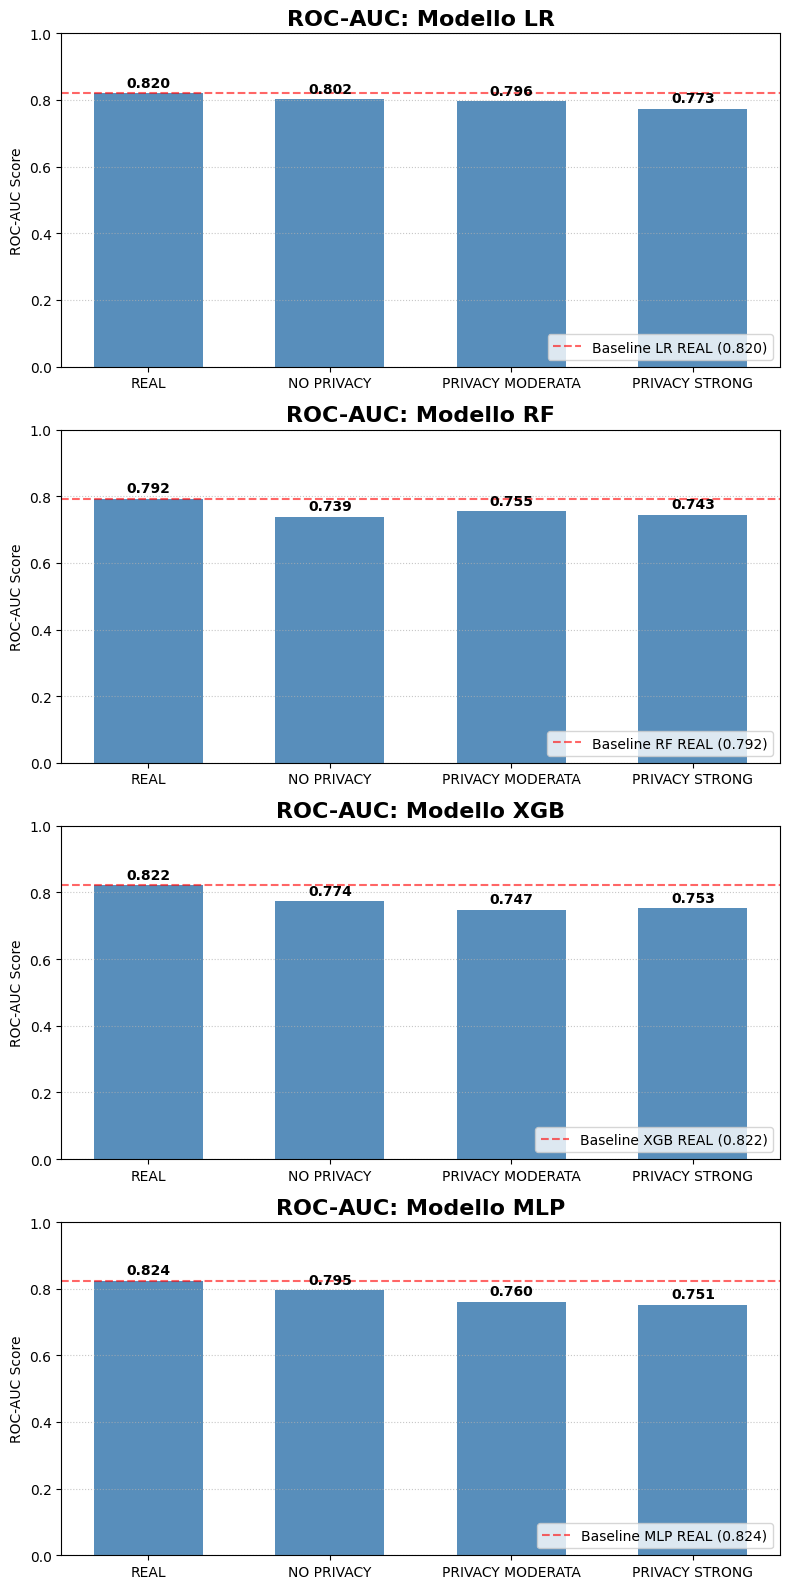

In [11]:
modelli = df_risultati['Modello'].unique()

fig, axes = plt.subplots(len(modelli), 1, figsize=(8, 4 * len(modelli)))

if len(modelli) == 1: axes = [axes]

for ax, mod in zip(axes, modelli):
    # Filtriamo i dati per il modello specifico
    df_mod = df_risultati[df_risultati['Modello'] == mod].copy()

    ordine = ['REAL', 'NO PRIVACY', 'PRIVACY MODERATA', 'PRIVACY STRONG','PRIVACY 2.0']
    df_mod['Configurazione'] = pd.Categorical(df_mod['Configurazione'], categories=ordine, ordered=True)
    df_mod = df_mod.sort_values('Configurazione')

    ax.bar(df_mod['Configurazione'], df_mod['ROC-AUC'], color='#4682B4', alpha=0.9, width=0.6)

    # Estrazione della baseline specifica per questo modello (valore REAL)
    try:
        baseline_val = df_mod[df_mod['Configurazione'] == 'REAL']['ROC-AUC'].values[0]
        ax.axhline(y=baseline_val, color='red', linestyle='--', alpha=0.6,
                   label=f'Baseline {mod} REAL ({baseline_val:.3f})')
    except IndexError:
        pass

    ax.set_title(f'ROC-AUC: Modello {mod}', fontweight='bold', fontsize=16)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel('ROC-AUC Score')
    ax.grid(axis='y', linestyle=':', alpha=0.7)
    ax.legend(loc='lower right')

    # Aggiunta etichette sopra le barre per precisione
    for i, v in enumerate(df_mod['ROC-AUC']):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## **VALUTARE LA PRIVACY**: implementare Membership Inference Attack per misurare la perdita di informazioni

In [12]:
# =======================Membership Inference Attack =======================
"""
Per ogni generatore sintetico (no-privacy, privacy moderata, privacy strong) costruisce feature che misurano quanto ogni record reale è
ben rappresentato dal sintetico (distanze k-NN, densità locale, errore di ricostruzione), addestra un classificatore XGBoost che
predice se un record appartiene al training set (membro) o al holdout (non-membro) e infine riporta accuratezza e AUC dell’attaccante.
   - Membri = diabetes_train.csv
   - Non-membri = diabetes_holdout
   - Feature MIA: k-NN distance + local density + recon error
   - Attaccante: classificatore supervisionato
"""

# Carica dataset reali e sintetici
df_real_train   = pd.read_csv("dataset/real/diabetes_train.csv")
df_real_holdout = pd.read_csv("dataset/real/diabetes_holdout.csv")

synthetic_noprivacy = pd.read_csv("dataset/synthetic/synthetic_no_privacy.csv")
synthetic_mod       = pd.read_csv("dataset/synthetic/synthetic_privacy_moderata.csv")
synthetic_strong    = pd.read_csv("dataset/synthetic/synthetic_privacy_strong.csv")

target_col = "outcome"
feature_cols = [c for c in df_real_train.columns if c != target_col]

# Campione fisso
sample_size = 5000
seed = 42
real_train_sample = df_real_train.sample(n=min(len(df_real_train), sample_size),random_state=seed)
real_holdout_sample = df_real_holdout.sample(n=min(len(df_real_holdout), sample_size), random_state=seed)

print(f"Usati {len(real_train_sample)} membri e {len(real_holdout_sample)} non-membri fissi per tutti i generatori.")

# Feature MIA: k-NN distance + local density
def compute_nn_and_density(real_df, synth_df, feature_cols, k, radius):
    """
    Per ogni record reale calcola:
      - dist_min: distanza al sintetico più vicino
      - dist_mean_k: media delle prime k distanze
      - density_r: numero di sintetici entro un raggio r (normalizzato)
    """
    X_real = real_df[feature_cols].values
    X_synth = synth_df[feature_cols].values

    # Standardizza
    scaler = StandardScaler()
    X_synth_std = scaler.fit_transform(X_synth)
    X_real_std  = scaler.transform(X_real)

    # k-NN distances
    knn = NearestNeighbors(n_neighbors=k, metric="euclidean", n_jobs=-1)
    knn.fit(X_synth_std)
    dists, _ = knn.kneighbors(X_real_std)
    dist_min = dists[:, 0]
    dist_mean_k = dists.mean(axis=1)

    # Local density entro r
    nn_radius = NearestNeighbors(radius=radius, metric="euclidean", n_jobs=-1)
    nn_radius.fit(X_synth_std)
    neigh_idx = nn_radius.radius_neighbors(X_real_std, return_distance=False)
    density_r = np.array([len(idx) for idx in neigh_idx], dtype=float)
    density_r /= (density_r.max() + 1e-8)  # normalizza

    feats = np.vstack([dist_min, dist_mean_k, density_r]).T
    return feats

# Feature MIA: errore di ricostruzione
def compute_reconstruction_error(real_df, synth_df, feature_cols):
    """
    Serve a misurare quanto un modello addestrato sui dati sintetici riesce a predire le feature dei record reali (errore di ricostruzione medio).
    Se il generatore non rappresenta bene x, l’errore sarà alto.

    Allena un regressore XGBRegressor su sintetico per predire ogni feature
    a partire dalle altre. Per ogni record reale calcola l'errore medio
    di ricostruzione sulle feature.
    """
    X_synth = synth_df[feature_cols].values
    X_real  = real_df[feature_cols].values

    scaler = StandardScaler()
    X_synth_std = scaler.fit_transform(X_synth)
    X_real_std  = scaler.transform(X_real)

    n_features = len(feature_cols)
    errors = np.zeros((X_real_std.shape[0], n_features))

    for j in range(n_features):
        idx_other = [i for i in range(n_features) if i != j]

        X_tr = X_synth_std[:, idx_other]
        y_tr = X_synth_std[:, j]

        model = XGBRegressor(
            n_estimators=50,
            max_depth=3,
            learning_rate=0.1,
            tree_method='hist',
            n_jobs=-1,
            random_state=42
        )
        model.fit(X_tr, y_tr)

        X_te = X_real_std[:, idx_other]
        y_te = X_real_std[:, j]
        y_pred = model.predict(X_te)

        errors[:, j] = (y_te - y_pred) ** 2

    mse_per_record = errors.mean(axis=1)
    return mse_per_record.reshape(-1, 1)

# Costruzione dataset MIA
def build_mia_dataset(real_train, real_holdout, synth_df):
    """
    Costruisce il dataset usato dall’attaccante, con etichette y=1 per membri (records di diabetes_train) e y=0 per non-membri (records di diabetes_holdout).

    Vettore di feature per ciascun record reale x:
      phi(x) = [dist_min, dist_mean_k, density_r, recon_error]
    calcolate rispetto a synth_df.
    """
    print(f"Calcolo feature MIA...")

    # Membri
    feats_nn_train  = compute_nn_and_density(real_train, synth_df, feature_cols, k=5, radius=1)
    feats_rec_train = compute_reconstruction_error(real_train, synth_df, feature_cols)
    X_mem = np.hstack([feats_nn_train, feats_rec_train])
    y_mem = np.ones(len(real_train), dtype=int)

    # Non-membri
    feats_nn_hold  = compute_nn_and_density(real_holdout, synth_df, feature_cols,k=5, radius=1)
    feats_rec_hold = compute_reconstruction_error(real_holdout, synth_df, feature_cols)
    X_non = np.hstack([feats_nn_hold, feats_rec_hold])
    y_non = np.zeros(len(real_holdout), dtype=int)

    X = np.vstack([X_mem, X_non])
    y = np.concatenate([y_mem, y_non])

    return X, y

# Attaccante supervisionato (XGBoost)
def run_mia_attack(X, y, test_size=0.3, seed=42):
    """
    Addestrare l’attaccante (classificatore XGBoost) sulle feature MIA e valutare accuracy e AUC.
    """
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )

    scaler = StandardScaler()
    X_tr_std = scaler.fit_transform(X_tr)
    X_te_std = scaler.transform(X_te)

    attacker = XGBClassifier(n_estimators=100, eval_metric="logloss", random_state=42)
    attacker.fit(X_tr_std, y_tr)

    proba = attacker.predict_proba(X_te_std)[:, 1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, pred)
    auc = roc_auc_score(y_te, proba)

    return acc, auc

# Esegui il MIA per ciascun generatore
results = {}

X_ctgan, y_ctgan = build_mia_dataset(real_train_sample, real_holdout_sample, synthetic_noprivacy)
results["CTGAN_no_privacy"] = run_mia_attack(X_ctgan, y_ctgan)

X_dp_mod, y_dp_mod = build_mia_dataset(real_train_sample, real_holdout_sample, synthetic_mod)
results["Privacy moderata"] = run_mia_attack(X_dp_mod, y_dp_mod)

X_dp_strong, y_dp_strong = build_mia_dataset(real_train_sample, real_holdout_sample, synthetic_strong)
results["Privacy strong"] = run_mia_attack(X_dp_strong, y_dp_strong)

#Stampa risultati
print("\n=== Membership Inference Attack ===")
print(f"{'Generatore':20s} {'ACC':>8s} {'AUC':>8s} {'PrivacyLoss':>14s}")

privacy_results = {}

for name, (acc, auc) in results.items():
    privacy_loss = auc - 0.5          # perdita di info assoluta
    privacy_adv  = 2 * (auc - 0.5)    # vantaggio normalizzato in [0,1]
    privacy_results[name] = {
        "acc": acc,
        "auc": auc,
        "privacy_loss": privacy_loss,
        "privacy_adv": privacy_adv
    }
    print(f"{name:20s} {acc:8.3f} {auc:8.3f} {privacy_loss:14.3f}")

df_privacy = pd.DataFrame.from_dict(privacy_results, orient="index")
df_privacy.index.name = "Generatore"

# Salva in CSV
df_privacy.to_csv("mia_results_summary.csv")


Usati 5000 membri e 5000 non-membri fissi per tutti i generatori.
Calcolo feature MIA...
Calcolo feature MIA...
Calcolo feature MIA...

=== Membership Inference Attack ===
Generatore                ACC      AUC    PrivacyLoss
CTGAN_no_privacy        0.686    0.793          0.293
Privacy moderata        0.630    0.713          0.213
Privacy strong          0.640    0.718          0.218


## **ANALISI TRADE-OFF PRIVACY-UTILITA'**

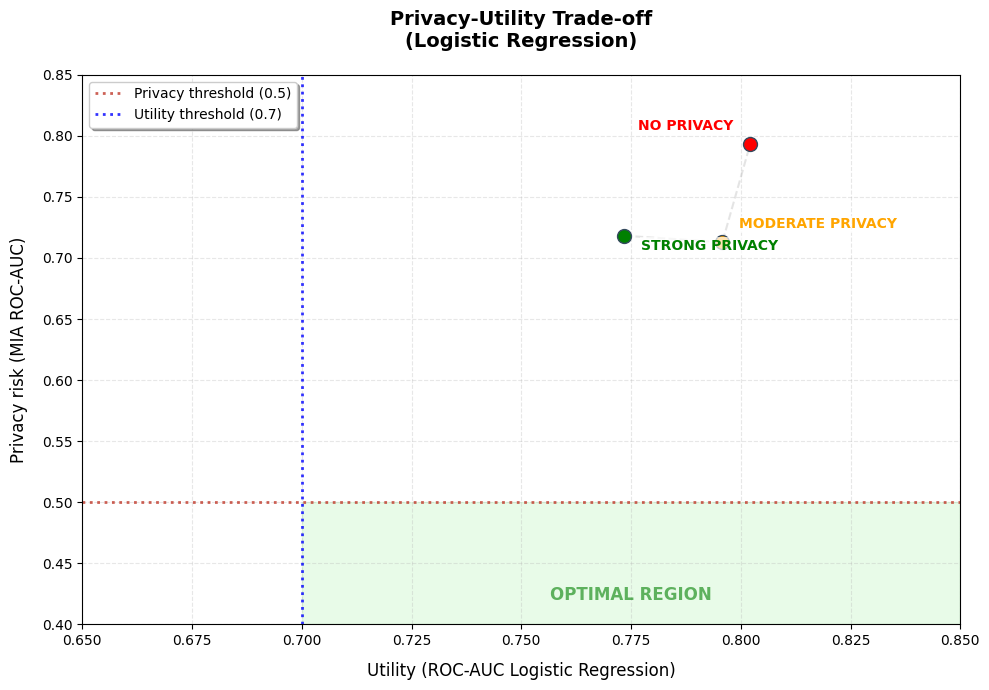

In [16]:
df_risultati = pd.read_csv("risultati_modelli_classificazione.csv")
df_lr_utility = df_risultati[df_risultati['Modello'] == 'LR'].copy()
df_mia = pd.read_csv("mia_results_summary.csv")

mappa_inversa = {
    'CTGAN_no_privacy': 'NO PRIVACY',
    'Privacy moderata': 'PRIVACY MODERATA',
    'Privacy strong': 'PRIVACY STRONG'
}
display_labels = {
    'NO PRIVACY': 'NO PRIVACY',
    'PRIVACY MODERATA': 'MODERATE PRIVACY',
    'PRIVACY STRONG': 'STRONG PRIVACY'
}
utility_auc, privacy_risk, labels = [], [], []

for _, row in df_mia.iterrows():
    config_name = mappa_inversa.get(row['Generatore'])
    util_row = df_lr_utility[df_lr_utility['Configurazione'] == config_name]
    if not util_row.empty:
        labels.append(config_name)
        privacy_risk.append(row['auc'])
        utility_auc.append(util_row['ROC-AUC'].values[0])

plt.figure(figsize=(10, 7))

# Colora il quadrante: Utilità > 0.7 e Privacy < 0.5
plt.fill_between(x=[0.7, 0.85], y1=0.4, y2=0.5,
                 color='lightgreen', alpha=0.2, zorder=0)
plt.text(0.775, 0.42, "OPTIMAL REGION", fontsize=12, fontweight='bold',
         color='green', alpha=0.6, ha='center')


# Linea di tendenza (grigia)
sort_idx = np.argsort(utility_auc)
plt.plot(np.array(utility_auc)[sort_idx], np.array(privacy_risk)[sort_idx],
         linestyle='--', color='lightgray', alpha=0.6, zorder=1)

colors_map = {'NO PRIVACY': 'red', 'PRIVACY MODERATA': 'orange', 'PRIVACY STRONG': 'green'}

for i in range(len(labels)):
    c = colors_map.get(labels[i], 'black')

    if labels[i] == 'PRIVACY STRONG':
        off_x, off_y = 12, -10
        align = 'left'
    elif labels[i] == 'NO PRIVACY':
        off_x, off_y = -12, 10
        align = 'right'
    else:
        off_x, off_y = 12, 10
        align = 'left'

    plt.scatter(utility_auc[i], privacy_risk[i], color=c, s=100, edgecolors='#34495e', linewidth=1, zorder=3)

    plt.annotate(display_labels[labels[i]], (utility_auc[i], privacy_risk[i]),
                 xytext=(off_x, off_y), textcoords='offset points',
                 fontweight='bold', fontsize=10, color=c, ha=align,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

plt.axhline(y=0.5, color='#c0392b', linestyle=':', linewidth=2, alpha=0.8, label='Privacy threshold (0.5)')
plt.axvline(x=0.7, color='blue', linestyle=':', linewidth=2, alpha=0.8, label='Utility threshold (0.7)')

plt.xlabel("Utility (ROC-AUC Logistic Regression)", fontsize=12, labelpad=10)
plt.ylabel("Privacy risk (MIA ROC-AUC)", fontsize=12, labelpad=10)
plt.title("Privacy-Utility Trade-off\n(Logistic Regression)", fontsize=14, fontweight='bold', pad=20)

plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(0.65, 0.85)
plt.ylim(0.40, 0.85)

plt.legend(loc='upper left', frameon=True, shadow=True, fontsize='medium')
plt.tight_layout()

plt.savefig("tradeoff_privacy_utility_LR.png", dpi=300)
plt.show()

## ESPERIMENTO epsilon = 0.1

In [ ]:
#esperimento
synthetic_esperimento = pd.read_csv("dataset/synthetic/synthetic_esperimento.csv")
metadata_esperimento = SingleTableMetadata()
metadata_esperimento.detect_from_dataframe(df)

In [ ]:
# PRIVACY ESPERIMENTO epsilon=0.1
print("Generazione privacy esperimento ...")
synthetic_esperimento, metadata_esperimento = synthetic_dpctgan(train_df, epsilon=0.1, model_path="models/privacy_esperimento.pkl")
synthetic_esperimento.to_csv("dataset/synthetic/synthetic_esperimento.csv", index=False)

ANALISI QUALITA' E SOMIGLIANZA STATISTICA DEI DATI SINTETICI - ESPERIMENTO

In [ ]:
diag_report, qual_report = valuta_qualita_dataset(train_df, synthetic_esperimento, metadata_esperimento, nome="ESPERIMENTO")

In [ ]:
somiglianza_statistica(train_df, synthetic_esperimento, metadata_esperimento, nome="ESPERIMENTO")

VALUTARE UTILITA' PER LA RICERCA: addestrare modelli di predizione delle malattie su dati sintetici e valutarli su un set reale di holdout

In [ ]:
X_test = holdout_df.drop('outcome', axis=1)
y_test = holdout_df['outcome']
risultati_finali2 = []
def valuta(y_true, y_pred, y_pred_proba, nome_modello, config_name):
    """Calcola le metriche, le stampa immediatamente e le salva."""
    res = {
        'Configurazione': config_name,
        'Modello': nome_modello,
        'Accuracy': accuracy_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0)
    }
    risultati_finali2.append(res)
    print(f"   {nome_modello} -> Accuracy: {res['Accuracy']:.4f} | ROC-AUC: {res['ROC-AUC']:.4f}")
    return res

def get_scale_weight(df):
    """Calcola lo scale_pos_weight basandosi sullo sbilanciamento del dataset fornito."""
    counts = df['outcome'].value_counts()
    return counts.get(0, 1) / counts.get(1, 1)

X_train_synth = synthetic_esperimento.drop('outcome', axis=1)
y_train_synth = synthetic_esperimento['outcome']
sw_synth = get_scale_weight(synthetic_esperimento)
print("Training su dati sintetici e testing su holdout\n")
# LR Synth
lr_s = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42).fit(X_train_synth, y_train_synth)
valuta(y_test, lr_s.predict(X_test), lr_s.predict_proba(X_test)[:, 1], "LR", "ESPERIMENTO")

# RF Synth
rf_s = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42).fit(X_train_synth, y_train_synth)
valuta(y_test, rf_s.predict(X_test), rf_s.predict_proba(X_test)[:, 1], "RF", "ESPERIMENTO")

# XGB Synth
xgb_s = XGBClassifier(n_estimators=100, scale_pos_weight=sw_synth, eval_metric='logloss', random_state=42).fit(X_train_synth, y_train_synth)
valuta(y_test, xgb_s.predict(X_test), xgb_s.predict_proba(X_test)[:, 1], "XGB", "ESPERIMENTO")

# MLP Synth
mlp_s = train_mlp(X_train_synth, y_train_synth)
valuta(y_test, mlp_s.predict(X_test), mlp_s.predict_proba(X_test)[:, 1], "MLP", nome_config)

# TABELLA RIASSUNTIVA FINALE
print("\n" + "-"*25 + "TABELLA RIASSUNTIVA FINALE" + "-"*25)
df_risultati2 = pd.DataFrame(risultati_finali2)
print(df_risultati2.to_string(index=False))

VALUTARE LA PRIVACY: implementare Membership Inference Attack per misurare la perdita di informazioni

In [ ]:
risultati_mia_esperimento = {}
X_dp2, y_dp2 = build_mia_dataset(real_train_sample, real_holdout_sample, synthetic_esperimento)
acc_dp2, auc_dp2 = run_mia_attack(X_dp2, y_dp2)
privacy_loss = auc_dp2 - 0.5

In [ ]:
name="Esperimento con epsilon=0.1"
#Stampa risultati
print("=== Membership Inference Attack ===")
print(f"{'Generatore':27s} {'ACC':>8s} {'AUC':>8s} {'PrivacyLoss':>14s}")
print(f"{name:20s} {acc_dp2:8.3f} {auc_dp2:8.3f} {privacy_loss:14.3f}")